In [237]:
# Importa bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy.integrate import odeint

In [238]:
# Função para deixar os eixos 3D igual (equivalente ao plt.axes('equal'))
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([0, z_middle + plot_radius])
# Fonte: https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to

#### Parâmetros

In [239]:
d_ar = 1.2 # Densidade do Ar [kg/m³]
g = 9.8 # Aceleração da Gravidade [m/s]

cl = 1 # Coeficiente de Lift (Magnus)
cd0 = 0.3 # Coeficiente de Arrasto

r = 0.105 # Raio da Bola [m]
m = 0.26 # Massa da Bola [kg]
A = pi*(r**2) # Álea Transversal da Bola [m²]

#### A Quadra de Volei

In [240]:
# Quadra: 9 mestros de largula por 18 metros de comprimento
# Rede: 2,43 metros de altura, localizada no meio da quadra (9 metros)

quadra_x = [0, 18, 18, 0, 0]
quadra_y = [-4.5, -4.5, 4.5, 4.5, -4.5]
quadra_z = [0, 0, 0, 0, 0]

rede_x = [9, 9, 9, 9, 9]
rede_y = [-4.5, -4.5, 4.5, 4.5, -4.5]
rede_z = [1.43, 2.43, 2.43, 1.43, 1.43]

#### Declarações iniciais

In [241]:
# Ângulos iniciais
tetha = radians(92) # Ângulo vertical
alpha = radians(0) # Ângulo horizontal

# Posição inicial
x0 = 0
y0 = 0
z0 = 3 # Nesse sistema, a altura está no eixo Z

# Decompondo a Velocidade inicial
v0 = 126.3/3.6 # dado em [km/h] transformado em [m/s]
vx0 = v0*sin(tetha)*cos(alpha)
vy0 = v0*sin(tetha)*sin(alpha)
vz0 = v0*cos(tetha)

# Decompondo a Velocidade Angular inicial
w = 2*(2*pi) # dado em [RPS] transformado em [rad]
wx = -w*cos(tetha)*cos(alpha)
wy = -w*cos(tetha)*sin(alpha)
wz = w*sin(tetha)
w_vetor = np.array([wx, wy, wz]) # Compondo o Vetor da velocidade angular

# Valores iniciais
info_0 = [x0, y0, z0, vx0, vy0, vz0]

# Definindo o Tempo
dt = 1e-3
tMax = 1+dt
t_lista = np.arange(0, tMax, dt)

#### Modelo

In [242]:
def modelo(info, t_lista, Cd):
    # Extraindo os Valores
    x = info[0]
    y = info[1]
    z = info[2]
    vx = info[3]
    vy = info[4]
    vz = info[5]

    v_vetor = np.array([vx, vy, vz]) # Compondo o vetor da velocidade
    
    v_xy = sqrt(vx**2 + vy**2) # Componente da velocidade em xy
    v = sqrt(v_xy**2 + vz**2) # Velocidade

    # Calculos dos ângulos
    cos_tetha = vz/v 
    sen_tetha = v_xy/v
    cos_alpha = vx/v_xy
    sen_alpha = vy/v_xy

    # Calculando a Força de Arrasto
    Fa = 0.5*d_ar*A*Cd*(v**2)
    Fa_x = -Fa*sen_tetha*cos_alpha
    Fa_y = -Fa*sen_tetha*sen_alpha
    Fa_z = -Fa*cos_tetha
    
    # Calculando a Força Magnus
    Fmag = 0.5*d_ar*pi*(r**3)*cl*np.cross(w_vetor, v_vetor)
    Fmag_x = Fmag[0]
    Fmag_y = Fmag[1]
    Fmag_z = Fmag[2]
    
    # Calculando a aceleração (dV_dt)
    dVx_dt = (Fa_x + Fmag_x)/m
    dVy_dt = (Fa_y + Fmag_y)/m
    dVz_dt = (-(m*g) + Fa_z + Fmag_z)/m

    if z <= 0: # Impedindo a bola de atravessar o chão
        return [0, 0, 0, 0 ,0 ,0]
    else:
        return [vx, vy, vz, dVx_dt ,dVy_dt ,dVz_dt]

#### Validação

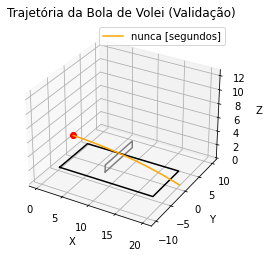

In [243]:
infos_Odeint = odeint(modelo, info_0, t_lista, args=(cd0,))

posX = list(infos_Odeint[:,0])
posY = list(infos_Odeint[:,1])
posZ = list(infos_Odeint[:,2])

# Dado: 0.267 segundos

for i, t in enumerate(t_lista):
    if posX[i] >= 9:
        tempo = t # Tempo decorrido para a bola bater na rede
        break

%matplotlib inline
# %matplotlib qt5
ax = plt.axes(projection='3d')
ax.plot3D(rede_x, rede_y, rede_z, color='grey') # rede
ax.plot3D(quadra_x, quadra_y, quadra_z, color='black') # quadra
ax.plot3D(posX[0], posY[0], posZ[0], 'ro') # Bola

ax.plot3D(posX, posY, posZ, color='orange', label=f"{tempo} [segundos]")
plt.title("Trajetória da Bola de Volei (Validação)")
plt.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
set_axes_equal(ax)
plt.show()

#### Gráfico Conclusivo
Esse código é muito pesado e leva cerca de 6 minutos para executar. Só descomente caso necessário

In [246]:
# lista_V = np.arange(90, 150, 0.5) # velocidades iniciais [km/h]
# lista_tetha = np.arange(80, 100, 0.5) # angulos verticais iniciais [°]
# lista_cd = np.arange(0.1, 0.6, 0.1) # coeficientes de arrasto

# %matplotlib qt5
# ax = plt.axes(projection='3d')

# for tetha in lista_tetha:
#     for V in lista_V:
#         for cd in lista_cd:

#             v0 = V/3.6
#             vx0 = v0*sin(tetha)*cos(alpha)
#             vy0 = v0*sin(tetha)*sin(alpha)
#             vz0 = v0*cos(tetha)

#             w = 2*(2*pi)
#             wx = -w*cos(tetha)*cos(alpha)
#             wy = -w*cos(tetha)*sin(alpha)
#             wz = w*sin(tetha)
#             w = np.array([wx, wy, wz])

#             info_0 = [x0, y0, z0, vx0, vy0, vz0]

#             infos_Odeint = odeint(modelo, info_0, t_lista, args=(cd,))

#             posX = list(infos_Odeint[:,0])
#             posY = list(infos_Odeint[:,1])
#             posZ = list(infos_Odeint[:,2])

#             rede = False
#             cor = "ro"
#             for i, t in enumerate(t_lista):
#                 if not rede and (posX[i] >= 9 and posZ[i]-r >= 2.43):
#                     rede = True
#                     cor = "yo"
#                 if rede and (posZ[i] <= 0 and posX[i] <= 18):
#                     cor = "go"
#                     ax.plot3D(tetha, V, cd, cor)
#                     print(f'ângulo: {tetha}°\nvelocidade: {V}km/h\nCoeficiênte de arrasto: {cd}\n')
#                     break 
            
# plt.title("Angulo Vertical [°] X Velocidade Inicial [km/h] X Coeficiente de Arrasto")
# ax.set_xlabel('Angulo Vertical [°]')
# ax.set_ylabel('Velocidade Inicial [km/h]')
# ax.set_zlabel('Coeficiente de Arrasto')
# plt.grid()
# plt.legend()
# plt.show()


ângulo: 80.0°
velocidade: 90.0km/h
Coeficiênte de arrasto: 0.1

ângulo: 89.5°
velocidade: 90.0km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 90.5km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 91.0km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 91.5km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 92.0km/h
Coeficiênte de arrasto: 0.1

ângulo: 89.5°
velocidade: 92.0km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 92.5km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 92.5km/h
Coeficiênte de arrasto: 0.5

ângulo: 89.5°
velocidade: 93.0km/h
Coeficiênte de arrasto: 0.4

ângulo: 89.5°
velocidade: 93.0km/h
Coeficiênte de arrasto: 0.5

ângulo: 89.5°
velocidade: 93.5km/h
Coeficiênte de arrasto: 0.1

ângulo: 89.5°
velocidade: 93.5km/h
Coeficiênte de arrasto: 0.5

ângulo: 89.5°
velocidade: 94.0km/h
Coeficiênte de arrasto: 0.5

ângulo: 89.5°
velocidade: 94.5km/h
Coeficiênte de arrasto: 0.5

ângulo: 89.5°
velocidade: 95.0km/h
Coefi

No handles with labels found to put in legend.
